Loss Function:
- Linear Regression: L1Loss (MAE: Mean Absolute Error)
- Binary Classification: BCELoss (Binary Crossentropy Loss)
- Multi-class Classification: CrossEntropyLoss


# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options.)

- [Book Version](https://learnpytorch.io/02_pytorch_classification/)
- [Ask a question](https://github.com/mrdbourke/pytorch-deep-learning/discussions)

## 1. Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples

n_samples = 1000

# Create circles
X,y = make_circles(n_samples, noise=0.03, random_state=42)

In [2]:
X.shape, y.shape

((1000, 2), (1000,))

In [3]:
#Visualize
print(f"First 5 samples of X\n")
print(X[:5])
print(f"First 5 samples of y\n")
print(y[:5])

First 5 samples of X

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y

[1 1 1 1 0]


In [4]:
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "labels":y})
circles.head()

,X1,X2,labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


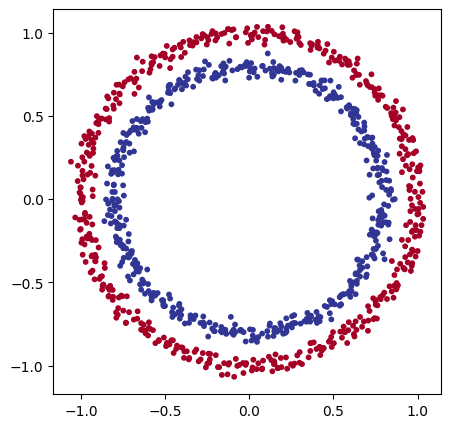

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.scatter(x = X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu,s=10)
plt.show()

**Note**: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

- [Toy Datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html)

### 1.1 Check input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and same for y: {y_sample}")
print(f"Shape for one sample of X: {X_sample.shape} and same for y: {y_sample.shape}")


Values for one sample of X: [0.75424625 0.23148074] and same for y: 1
Shape for one sample of X: (2,) and same for y: ()


In [8]:
import torch
import torch.nn as nn

In [9]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [10]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

I've reached 9:31:00

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we wnat to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [11]:
#Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we've setup device agnostic code, let's create a mdoel that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model calss and send it to the target `device`

In [12]:
from sklearn import datasets
# 1. Cosntruct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self,):
        super().__init__()

        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
        self.layer2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)

    # Define a forward method that outlines the forward pass
    def forward(self, x):
        return self.layer2(x) # x -> layer_1 -> layer-2 -> output

In [13]:
# Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0()
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
next(model_0.parameters())

Parameter containing:
tensor([[-0.0638, -0.6160],
        [-0.6738, -0.5178],
        [ 0.3274, -0.4069],
        [-0.2650,  0.1686],
        [ 0.4425, -0.3640]], requires_grad=True)

In [15]:
# Lets replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.7045, -0.3730],
                      [-0.0657, -0.2022],
                      [-0.6262,  0.3496],
                      [-0.6116, -0.4152],
                      [ 0.2868,  0.4031]])),
             ('0.bias', tensor([-0.1863, -0.5384,  0.5637, -0.2601,  0.4083])),
             ('1.weight',
              tensor([[ 0.3249,  0.0431, -0.1131, -0.3044, -0.3850]])),
             ('1.bias', tensor([-0.3055]))])

In [17]:
# Make Predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test)
print(f"Length of prediction: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")


Length of prediction: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.8061],
        [-0.7156],
        [-0.7305],
        [-0.8289],
        [-0.2336],
        [-0.1822],
        [-0.3211],
        [-0.1949],
        [-0.7515],
        [-0.7040]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [18]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

## 2.1 set up loss function and optimizer

Which loss function or optimizer should you use ?

Again... this is problem specific.

For example for regression you might want MAE or MSE(mean absolute error or mean squared error)

For Classification you might want binary cross entropy or categrorical cross entropy (cross entropy)

As a remainder, loss function measures how **wrong** your models predictions are.

And for optimizers, two most common and useful are SGD and Adam, however PyTorch has many built-in options.

- For some common choices of loss functions and optimizers -
- For the loss function we're going to use `torch.nn.BCEWithLogitLoss()`, for more on what binary cross entropy (BCE) is, check out this article - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
- For a defination on what a logit is in deep learning - https://stackoverflow.com/a/52111173/7900723

- For different optimizers see `torch.optim`

In [19]:
# Setup the loss function
loss_fn = nn.BCELoss() # requires input to have gone through the sigmoid function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [20]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.7045, -0.3730],
                      [-0.0657, -0.2022],
                      [-0.6262,  0.3496],
                      [-0.6116, -0.4152],
                      [ 0.2868,  0.4031]])),
             ('0.bias', tensor([-0.1863, -0.5384,  0.5637, -0.2601,  0.4083])),
             ('1.weight',
              tensor([[ 0.3249,  0.0431, -0.1131, -0.3044, -0.3850]])),
             ('1.bias', tensor([-0.3055]))])

In [21]:
# calculate accuracy
# formula: True Positive / (True Positive + True Negative) * 100
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/ len(y_pred)) * 100
    return acc

In [22]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

## 3. Train model

To train our model, we're going to need to build a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backpropagation (Backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

we can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to prediction labels by either rounding them or taking the **argmax()**

### Training our model_0:
- Hope we'll get the decision boundary we wanted to have.

In [23]:
torch.manual_seed(42)

epochs = 100

for epoch in range(epochs):

    #Training
    model_0.train()

    # forward
    y_pred_probs = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_pred_probs))

    # calculate loss
    loss = loss_fn(y_pred_probs, y_train)
    acc = accuracy_fn(y_preds, y_train)

    # optimizer zero grad
    optimizer.zero_grad()

    # backpropagation
    loss.backward()

    # optimizer step (gradient descent)
    optimizer.step()

    #Testing

    # model evaluation
    model_0.eval()

    with torch.inference_mode():
        y_predict_probs = model_0(X_test).squeeze()
        y_predicts = torch.round(torch.sigmoid(y_predict_probs))
        test_loss = loss_fn(y_predict_probs,y_test)
        test_acc = accuracy_fn(y_predicts, y_test)

    if epoch % 10 ==0 :
        print(f"Epoch: {epoch}  |   Loss: {loss:.3f}    |   accuracy: {acc:.3f} |   Test loss: {test_loss:.3f}  |   test accuracy: {test_acc:.3f}")

Epoch: 0  |   Loss: 0.736    |   accuracy: 50.000 |   Test loss: 0.736  |   test accuracy: 50.000
Epoch: 10  |   Loss: 0.732    |   accuracy: 50.000 |   Test loss: 0.732  |   test accuracy: 50.000
Epoch: 20  |   Loss: 0.729    |   accuracy: 50.000 |   Test loss: 0.729  |   test accuracy: 50.000
Epoch: 30  |   Loss: 0.725    |   accuracy: 50.000 |   Test loss: 0.725  |   test accuracy: 50.000
Epoch: 40  |   Loss: 0.722    |   accuracy: 50.000 |   Test loss: 0.722  |   test accuracy: 50.000
Epoch: 50  |   Loss: 0.719    |   accuracy: 50.000 |   Test loss: 0.720  |   test accuracy: 50.000
Epoch: 60  |   Loss: 0.717    |   accuracy: 49.875 |   Test loss: 0.717  |   test accuracy: 50.000
Epoch: 70  |   Loss: 0.715    |   accuracy: 49.250 |   Test loss: 0.715  |   test accuracy: 49.500
Epoch: 80  |   Loss: 0.713    |   accuracy: 47.000 |   Test loss: 0.713  |   test accuracy: 48.500
Epoch: 90  |   Loss: 0.711    |   accuracy: 45.125 |   Test loss: 0.712  |   test accuracy: 47.500


In [24]:
from helper_function import plot_decision_boundary

In [25]:
import matplotlib.pyplot as plt

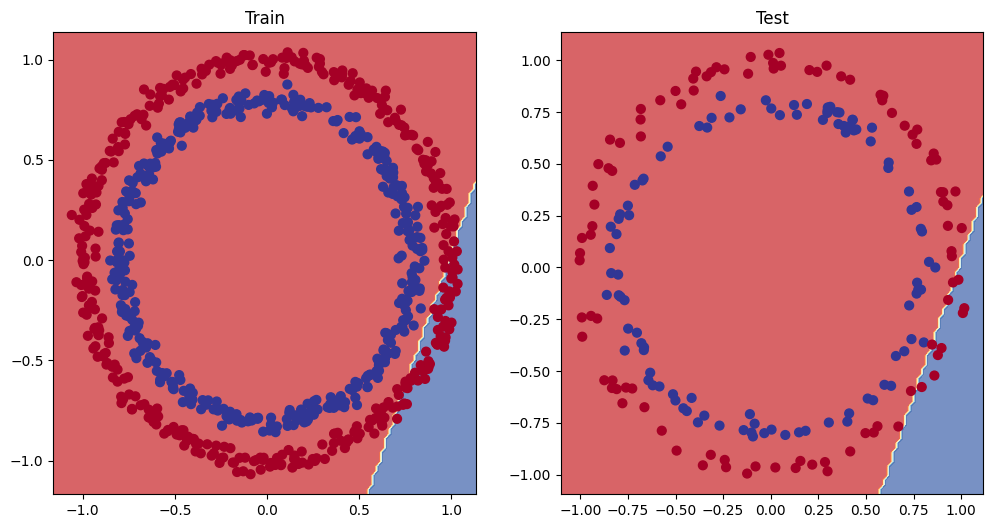

In [26]:
# plotting decision boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)


## Possible solution for issues with our model.
- Increasea the number of Hidden layers
- Increase the number of epochs
- Change the learning rate
- Change the activation function
- Change the loss function

**Approach**: lets change the activation function and see what happens. 

The values that we (data scientists, machine learning engineers) can change in our models are called `hyperparameters`. and the process of changing them is called  **`Hyperparameter tuning.`**


### Making another CircleModel => CircleModelV1

In [27]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x
    
model_1 = CircleModelV1()
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [28]:
## setting up loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_1.parameters(), lr=0.1)

In [29]:
torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):

    #Training
    model_1.train()

    # forward
    y_pred_probs = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_pred_probs))

    # calculate loss
    loss = loss_fn(y_pred_probs, y_train)
    acc = accuracy_fn(y_preds, y_train)

    # optimizer zero grad
    optimizer.zero_grad()

    # backpropagation
    loss.backward()

    # optimizer step (gradient descent)
    optimizer.step()

    #Testing

    # model evaluation
    model_1.eval()

    with torch.inference_mode():
        y_predict_probs = model_1(X_test).squeeze()
        y_predicts = torch.round(torch.sigmoid(y_predict_probs))
        test_loss = loss_fn(y_predict_probs,y_test)
        test_acc = accuracy_fn(y_predicts, y_test)

    if epoch % 10 ==0 :
        print(f"Epoch: {epoch}  |   Loss: {loss:.3f}    |   accuracy: {acc:.3f} |   Test loss: {test_loss:.3f}  |   test accuracy: {test_acc:.3f}")

Epoch: 0  |   Loss: 0.693    |   accuracy: 50.000 |   Test loss: 0.693  |   test accuracy: 50.000
Epoch: 10  |   Loss: 0.692    |   accuracy: 50.500 |   Test loss: 0.693  |   test accuracy: 50.000
Epoch: 20  |   Loss: 0.692    |   accuracy: 59.125 |   Test loss: 0.692  |   test accuracy: 56.500
Epoch: 30  |   Loss: 0.692    |   accuracy: 70.250 |   Test loss: 0.692  |   test accuracy: 68.000
Epoch: 40  |   Loss: 0.692    |   accuracy: 68.375 |   Test loss: 0.692  |   test accuracy: 71.000
Epoch: 50  |   Loss: 0.692    |   accuracy: 58.250 |   Test loss: 0.692  |   test accuracy: 58.000
Epoch: 60  |   Loss: 0.692    |   accuracy: 54.000 |   Test loss: 0.692  |   test accuracy: 54.500
Epoch: 70  |   Loss: 0.692    |   accuracy: 53.125 |   Test loss: 0.691  |   test accuracy: 53.000
Epoch: 80  |   Loss: 0.691    |   accuracy: 52.625 |   Test loss: 0.691  |   test accuracy: 53.000
Epoch: 90  |   Loss: 0.691    |   accuracy: 52.750 |   Test loss: 0.691  |   test accuracy: 53.000
Epoch: 100 

In [30]:
y_pred_probs[:5], y_preds[:5]

(tensor([ 0.2165, -0.4163, -0.1776, -0.0779,  0.2054], grad_fn=<SliceBackward0>),
 tensor([1., 0., 0., 0., 1.], grad_fn=<SliceBackward0>))

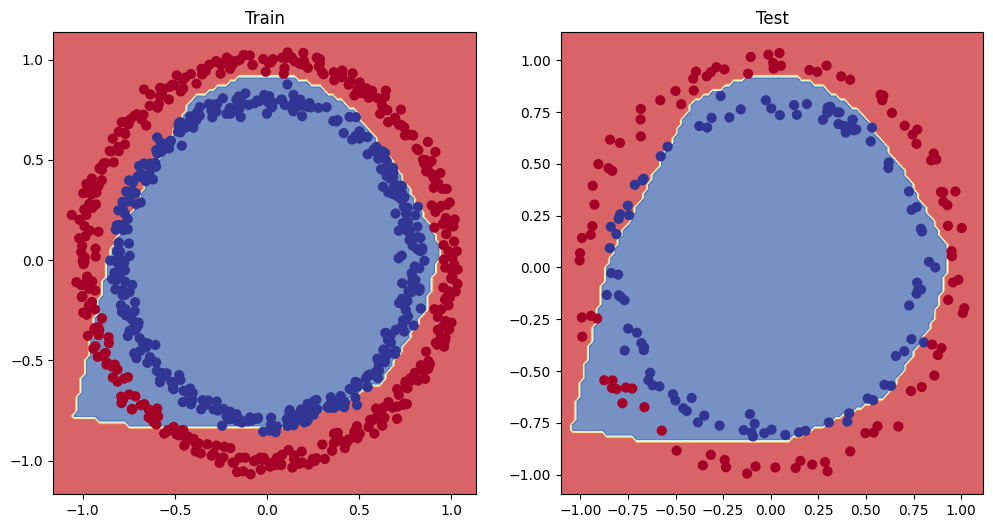

In [31]:
# plotting decision boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)


### model_1 worked not just because we've changed the activation function.
- Why ReLU worked but Linear didn't ?

> Linear function are great for linear datasets. but wtf is linear ?
Linear means straight line. like when plotted gives a straight line. You can see the diagram below.

> model_0 has linear functions only. Linear function doesn't learn in non-linear dataset. ReLU is a non-linear activation function introduced in model_1 and then creates a non-linear decision boundary which perfectly separates red dots with blue dots.

In [32]:
import numpy as np

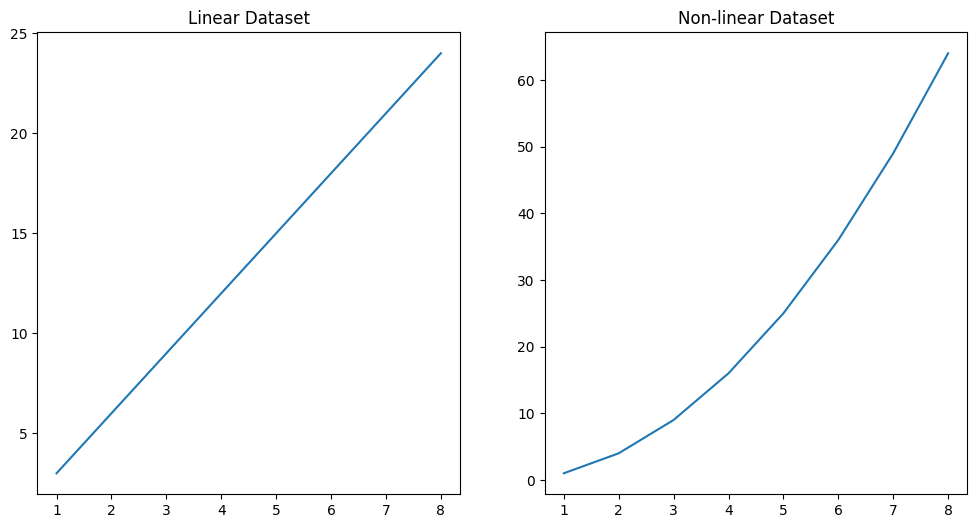

In [33]:
# plotting decision boundary
p = np.array([1,2,3,4,5,6,7,8])
q = np.array([3,6,9,12,15,18,21,24])
r = np.array([1,4,9,16,25,36,49,64])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Linear Dataset")
plt.plot(p,q)
plt.subplot(1,2,2)
plt.title("Non-linear Dataset")
plt.plot(p,r)


### Replicating non-linear activation functions

Neural networks, rather than us tellin gthe model what to learn, we give it the tools to discover patterns in data and it learns patterns on its own.

and these tools are linear and non-linear functions.

In [34]:
# create a tensor
A = torch.arange(start=-10, end=10, step=1, dtype=torch.float)
A.dtype

torch.float32

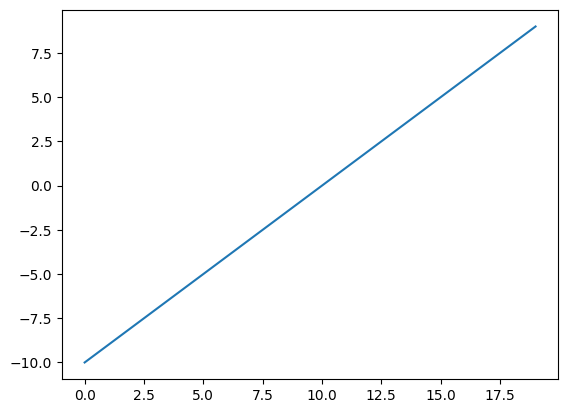

In [35]:
# Visualize the data
plt.plot(A)

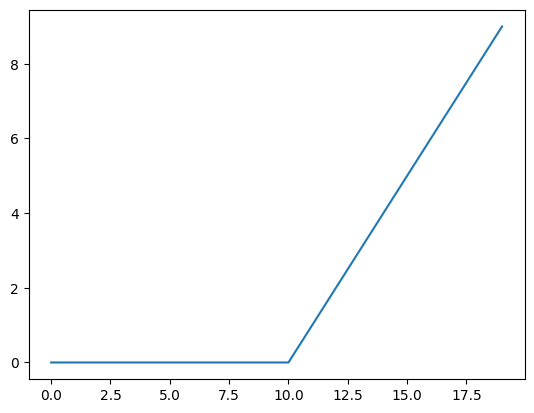

In [36]:
# performing ReLu function on A
plt.plot(torch.relu(A))

In [37]:
# replicating ReLU function max(0,x)
def relu(x: torch.Tensor) ->torch.Tensor:
    return torch.max(torch.tensor(0),x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

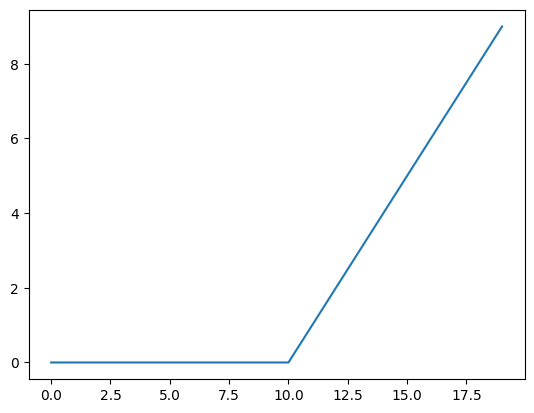

In [38]:
# plot ReLU activation function
plt.plot(relu(A))

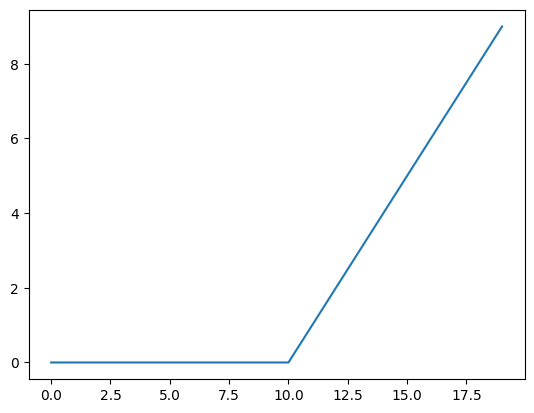

In [39]:
# performing ReLu function on A
plt.plot(torch.relu(A))

In [40]:
# replicating Sigmoid function: 1/(1+e^-x)
def sigmoid(x: torch.Tensor) ->torch.Tensor:
    # s = 1/(1+ torch.exp(-x))
    return torch.tensor(1/(1+ torch.exp(-x)))

sigmoid(A)

C:\Users\bisha\AppData\Local\Temp\ipykernel_26412\4128638399.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1/(1+ torch.exp(-x)))


tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

C:\Users\bisha\AppData\Local\Temp\ipykernel_26412\4128638399.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(1/(1+ torch.exp(-x)))


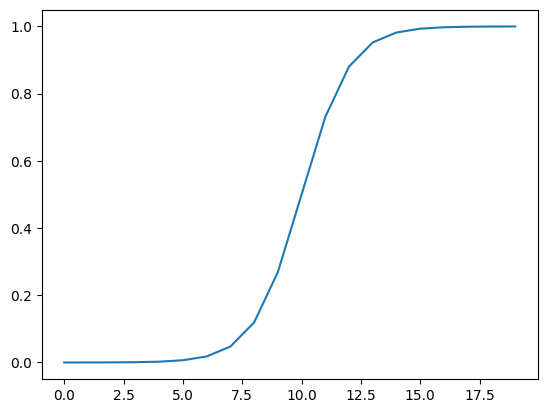

In [41]:
# plot Sigmoid activation function
plt.plot(sigmoid(A))

## Putting it all together with a multiclass classification problem

- Binary classification = one thing or another (cat vs dog, spam vs non-spam, fraud or not fraud, etc)
- Multi-class classification = more than one thing or the other (cat vs dog vs chicken)

## 8.1 Creating a toy multi-class dataset

In [42]:
# import dependencies

import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs 
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers = NUM_CLASSES,
    cluster_std = 1.5,
    random_state= RANDOM_SEED
)
X_blob[:5], y_blob[:5]

#2. Turn data into numpy
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_blob,y_blob, test_size=0.2, random_state=RANDOM_SEED)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

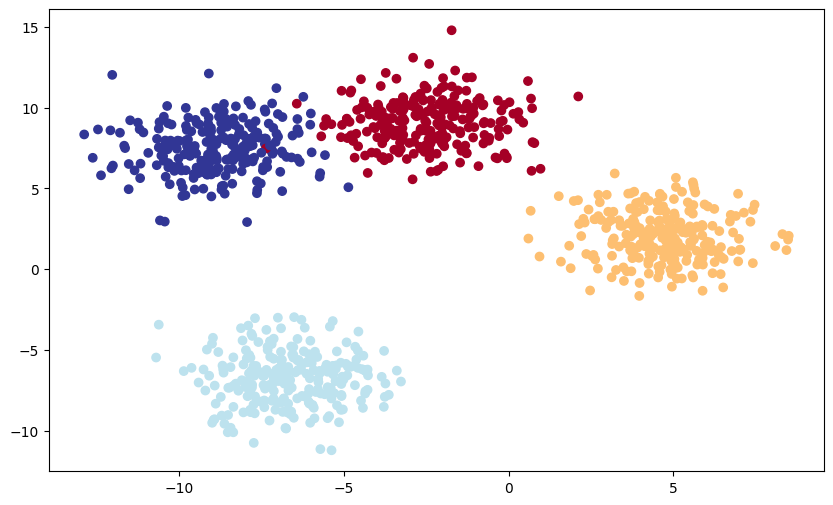

In [43]:
plt.figure(figsize=(10,6))
plt.scatter(X_blob[:,0],X_blob[:,1], c=y_blob, cmap = plt.cm.RdYlBu)
plt.show()


### 8.2 Building a multi-class classification model in PyTorch

In [44]:
# 1. Create device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [45]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units= 8):
        super().__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features=output_features)

        )

    def forward(self,x: torch.Tensor)-> torch.Tensor:
        return self.linear_layer_stack(x)
    
# Create an instance of BlobModel and send it to the target device
model_2 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_2

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [46]:
# multi-class classification loss function
criterion = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params =model_2.parameters(),lr=0.1)

### Getting probabilites for multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

- Logits -> Pred probs -> Pred labels

In [47]:
with torch.inference_mode():
    y_logits = model_2(X_test)

y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:5]
    

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])

In [48]:
torch.argmax(y_pred_probs[0])

tensor(1)

In [49]:
# convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [50]:
y_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [51]:
acc = accuracy_fn(y_test,y_preds)
acc

35.5

### 8.5 Creating a training and testing loop for a multi-class PyTorch model

In [54]:
torch.manual_seed(42)

epochs = 100

for epoch in range(epochs):

    # Training
    model_2.train()

    # forward
    y_logits = model_2(X_train).squeeze()
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # loss function
    loss = criterion(y_logits,y_train)
    acc = accuracy_fn(y_train, y_preds)

    # optimizer zero grad
    optimizer.zero_grad()

    # backward propagation
    loss.backward()

    # optimizer step (gradient descent)
    optimizer.step()

    # Testing 
    model_2.eval()

    with torch.inference_mode():
        test_logits = model_2(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = criterion(test_logits,y_test)
        test_acc = accuracy_fn(y_test,test_preds)

    # print out what's happening:
    if epoch % 10 ==0:
        print(f"Epoch: {epoch}  |   training loss: {loss:.5f}   |   training accuracy: {acc:.3f}%    |   test loss: {test_loss:.5f}  |   test accuracy: {test_acc:.3f}%")

Epoch: 0  |   training loss: 0.03312   |   training accuracy: 99.250%    |   test loss: 0.02433  |   test accuracy: 99.500%
Epoch: 10  |   training loss: 0.03160   |   training accuracy: 99.250%    |   test loss: 0.02261  |   test accuracy: 99.500%
Epoch: 20  |   training loss: 0.03044   |   training accuracy: 99.250%    |   test loss: 0.02126  |   test accuracy: 99.500%
Epoch: 30  |   training loss: 0.02958   |   training accuracy: 99.250%    |   test loss: 0.02022  |   test accuracy: 99.500%
Epoch: 40  |   training loss: 0.02889   |   training accuracy: 99.250%    |   test loss: 0.01940  |   test accuracy: 99.500%
Epoch: 50  |   training loss: 0.02833   |   training accuracy: 99.250%    |   test loss: 0.01872  |   test accuracy: 99.500%
Epoch: 60  |   training loss: 0.02787   |   training accuracy: 99.250%    |   test loss: 0.01815  |   test accuracy: 99.500%
Epoch: 70  |   training loss: 0.02747   |   training accuracy: 99.250%    |   test loss: 0.01766  |   test accuracy: 99.500%
E

In [53]:
y_logits.dtype, y_train.dtype

(torch.float32, torch.int64)

In [57]:
# Make predictions
model_2.eval()
with torch.inference_mode():
    y_logits = model_2(X_test)

y_logits[:10]

tensor([[ -0.8251,   7.4214,  -8.6492,  -9.6438],
        [ -2.4384,  -7.2530,  -4.4771,   4.0202],
        [ -4.1930,  -4.6251,   3.9723,  -3.1864],
        [ -1.4889,   5.2914,  -4.4613,  -5.5503],
        [  4.8179,  -1.4412, -10.3127,  -7.9953],
        [ -3.1214,  -8.6418,  -5.1784,   4.7837],
        [ -3.7127,  -3.9668,   3.4995,  -2.6344],
        [  4.2985,  -4.6856,  -7.8447,  -4.0603],
        [ -5.3360,  -5.9068,   4.8426,  -4.0999],
        [  4.4805,  -3.4720,  -8.5458,  -5.3922]])

In [58]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[2.6209e-04, 9.9974e-01, 1.0483e-07, 3.8775e-08],
        [1.5643e-03, 1.2687e-05, 2.0366e-04, 9.9822e-01],
        [2.8397e-04, 1.8436e-04, 9.9875e-01, 7.7710e-04],
        [1.1346e-03, 9.9879e-01, 5.8071e-05, 1.9543e-05],
        [9.9809e-01, 1.9093e-03, 2.6793e-07, 2.7194e-06],
        [3.6871e-04, 1.4764e-06, 4.7133e-05, 9.9958e-01],
        [7.3492e-04, 5.7004e-04, 9.9653e-01, 2.1606e-03],
        [9.9963e-01, 1.2535e-04, 5.3225e-06, 2.3425e-04],
        [3.7967e-05, 2.1454e-05, 9.9981e-01, 1.3069e-04],
        [9.9959e-01, 3.5163e-04, 2.2008e-06, 5.1539e-05]])

In [59]:
y_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [62]:
y_preds = y_pred_probs.argmax(dim=1)
y_preds

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [63]:
accuracy_fn(y_test,y_preds)

99.5

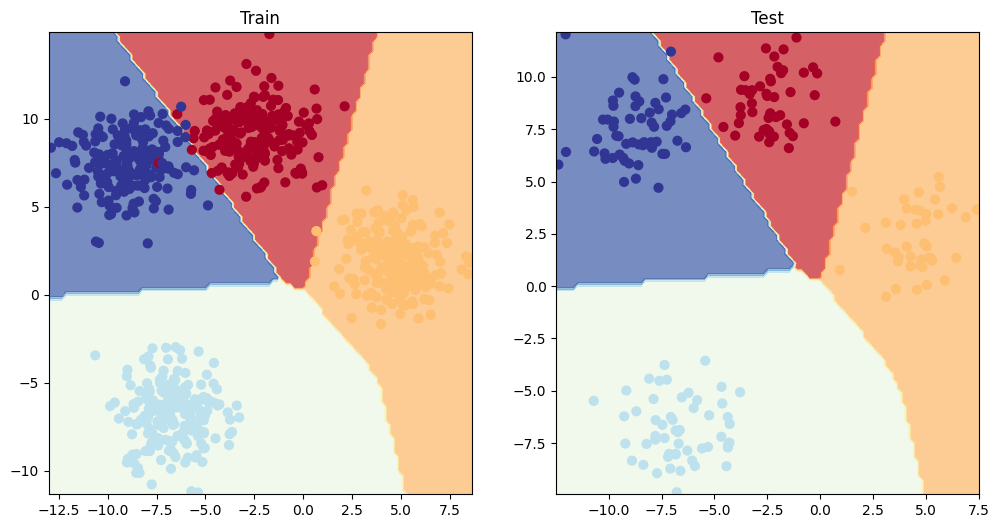

In [56]:
# plotting decision boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2,X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2,X_test,y_test)


### 9. A few more classification metrics ... (to evaluate our classification model)

`torchmetrics`

- Accuracy - out of 100 samples, how many does our model get right
- Precision 
- Recall
- F1 Score
- Confusion matrix
- Classification report